In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from transformers import pipeline
import urllib3
from urllib3 import request
import certifi
import json
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)

In [2]:
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [3]:

url ="https://datasets-server.huggingface.co/rows?dataset=amazon_us_reviews&config=Video_Games_v1_00&split=train&offset=0&limit=100"
r = http.request('GET', url)
r.status

200

In [4]:
data = json.loads(r.data.decode('utf-8'))
data

{'features': [{'feature_idx': 0,
   'name': 'marketplace',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 1,
   'name': 'customer_id',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 2,
   'name': 'review_id',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 3,
   'name': 'product_id',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 4,
   'name': 'product_parent',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 5,
   'name': 'product_title',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 6,
   'name': 'product_category',
   'type': {'dtype': 'string', '_type': 'Value'}},
  {'feature_idx': 7,
   'name': 'star_rating',
   'type': {'dtype': 'int32', '_type': 'Value'}},
  {'feature_idx': 8,
   'name': 'helpful_votes',
   'type': {'dtype': 'int32', '_type': 'Value'}},
  {'feature_idx': 9,
   'name': 'total_votes',
   'type': {'dtype': 'int32', '_type': 'Value'}},
  

In [5]:
df = pd.json_normalize(data, 'rows')
df.head(7)

,row_idx,truncated_cells,row.marketplace,row.customer_id,row.review_id,row.product_id,row.product_parent,row.product_title,row.product_category,row.star_rating,row.helpful_votes,row.total_votes,row.vine,row.verified_purchase,row.review_headline,row.review_body,row.review_date
0,0,[],US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,0,1,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,1,[],US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,0,1,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,2,[],US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,0,1,One Star,poor quality work and not as it is advertised.,2015-08-31
3,3,[],US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,0,1,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,4,[],US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,0,1,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31
5,5,[],US,2377552,R3AQQ4YUKJWBA6,B002UBI6W6,328764615,Psyclone Recharge Station for Nintendo Wii 4 P...,Video Games,1,0,0,0,1,One Star,The remote constantly have to be adjusted in o...,2015-08-31
6,6,[],US,17521011,R2F0POU5K6F73F,B008XHCLFO,24234603,Protection for your 3DS XL,Video Games,5,0,0,0,1,A Must,I have a 2012-2013 XL and this is very durable...,2015-08-31


In [6]:
df.shape

(100, 17)

In [7]:
column = ['row_idx','truncated_cells','row.marketplace','row.product_parent','row.product_category','row.helpful_votes','row.total_votes','row.vine','row.verified_purchase','row.review_date']
df = df.drop(columns=column, axis=1)
df.head()

,row.customer_id,row.review_id,row.product_id,row.product_title,row.star_rating,row.review_headline,row.review_body
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,5,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am..."
1,9636577,R1ZV7R40OLHKD,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gamin...,5,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami..."
2,2331478,R3BH071QLH8QMC,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fatef...,1,One Star,poor quality work and not as it is advertised.
3,52495923,R127K9NTSXA2YH,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation ...,3,"good, but could be bettee","nice, but tend to slip away from stick in inte..."
4,14533949,R32ZWUXDJPW27Q,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super S...,4,Great but flawed.,"Great amiibo, great for collecting. Quality ma..."


In [8]:
df.shape

(100, 7)

In [9]:
df.keys()

Index(['row.customer_id', 'row.review_id', 'row.product_id',
       'row.product_title', 'row.star_rating', 'row.review_headline',
       'row.review_body'],
      dtype='object')

In [10]:
pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch: started
    Running setup.py install for pytorch: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'c:\Users\Vishnu\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Vishnu\\AppData\\Local\\Temp\\pip-install-s7p5b9u5\\pytorch\\setup.py'"'"'; __file__='"'"'C:\\Users\\Vishnu\\AppData\\Local\\Temp\\pip-install-s7p5b9u5\\pytorch\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Vishnu\AppData\Local\Temp\pip-wheel-l0g4b6yh'
       cwd: C:\Users\Vishnu\AppData\Local\Temp\pip-install-s7p5b9u5\pytorch\
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\Vishnu\AppData\Local\Temp\pip-install-s7p5b9u5\pytorch\setup.py", line 15, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  ------------

In [12]:
from transformers import pipeline
roberta_large_pipeline = pipeline("sentiment-analysis", model="roberta-large")

c:\Users\Vishnu\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vishnu\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_

In [15]:
roberta_large_pipeline("THe products is trash")

[{'label': 'LABEL_1', 'score': 0.5413670539855957}]

In [ ]:
l=[]
for i in tqdm(df['row.review_body'], total=len(df['row.review_body'])):
    l.append(sent_pipeline(i)[0]['label'])
l

In [ ]:
df["pipeline score"] = l

In [ ]:
df

,row.customer_id,row.review_id,row.product_id,row.product_title,row.star_rating,row.review_headline,row.review_body,pipeline score
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,5,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",POSITIVE
1,9636577,R1ZV7R40OLHKD,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gamin...,5,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",POSITIVE
2,2331478,R3BH071QLH8QMC,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fatef...,1,One Star,poor quality work and not as it is advertised.,NEGATIVE
3,52495923,R127K9NTSXA2YH,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation ...,3,"good, but could be bettee","nice, but tend to slip away from stick in inte...",NEGATIVE
4,14533949,R32ZWUXDJPW27Q,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super S...,4,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",POSITIVE
...,...,...,...,...,...,...,...,...
95,4310666,R2AO4LQ4LEOCAG,B00J5S9Y32,Proimb Vertical Stand with Cooling Fan for Pla...,4,Super nice base,Super nice base. It shoulb be a little more wi...,POSITIVE
96,19633477,R3UF8G7L67JA2Y,B00B98HF1O,LEGO: Marvel,5,Great game,My 7 year old daughter and I love this game. W...,POSITIVE
97,40672081,R27RYQMIVSCO33,B00BGA9WK2,PlayStation 4 500GB Console [Old Model],5,Who needs reviews for buying a PS4! Stop wasti...,Do you need a review for the PS4!!!,NEGATIVE
98,1453081,R894FRA0USAUF,B0050SXPBI,Carnival Island - Playstation 3,4,Four Stars,this is a fun little game for the family,POSITIVE


In [ ]:
v=[]
analyzer = SentimentIntensityAnalyzer()
for i in tqdm(df['row.review_body'], total=len(df['row.review_body'])):
    senti = analyzer.polarity_scores(i)
    if senti['compound'] >= 0.05:
        v.append('POSITIVE')
    elif senti['compound'] <= -0.05:
        v.append('NEGATIVE')
    else:
        v.append('NEUTRAL')


100%|██████████| 100/100 [00:00<00:00, 2772.82it/s]


100

In [ ]:
df["VADER score"] = v
df

,row.customer_id,row.review_id,row.product_id,row.product_title,row.star_rating,row.review_headline,row.review_body,pipeline score,VADER score
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,5,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",POSITIVE,POSITIVE
1,9636577,R1ZV7R40OLHKD,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gamin...,5,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",POSITIVE,POSITIVE
2,2331478,R3BH071QLH8QMC,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fatef...,1,One Star,poor quality work and not as it is advertised.,NEGATIVE,NEGATIVE
3,52495923,R127K9NTSXA2YH,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation ...,3,"good, but could be bettee","nice, but tend to slip away from stick in inte...",NEGATIVE,POSITIVE
4,14533949,R32ZWUXDJPW27Q,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super S...,4,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",POSITIVE,POSITIVE
...,...,...,...,...,...,...,...,...,...
95,4310666,R2AO4LQ4LEOCAG,B00J5S9Y32,Proimb Vertical Stand with Cooling Fan for Pla...,4,Super nice base,Super nice base. It shoulb be a little more wi...,POSITIVE,POSITIVE
96,19633477,R3UF8G7L67JA2Y,B00B98HF1O,LEGO: Marvel,5,Great game,My 7 year old daughter and I love this game. W...,POSITIVE,POSITIVE
97,40672081,R27RYQMIVSCO33,B00BGA9WK2,PlayStation 4 500GB Console [Old Model],5,Who needs reviews for buying a PS4! Stop wasti...,Do you need a review for the PS4!!!,NEGATIVE,NEUTRAL
98,1453081,R894FRA0USAUF,B0050SXPBI,Carnival Island - Playstation 3,4,Four Stars,this is a fun little game for the family,POSITIVE,POSITIVE


In [ ]:
neutral = df[df['VADER score'] == 'NEUTRAL']
neutral

,row.customer_id,row.review_id,row.product_id,row.product_title,row.star_rating,row.review_headline,row.review_body,pipeline score,VADER score
5,2377552,R3AQQ4YUKJWBA6,B002UBI6W6,Psyclone Recharge Station for Nintendo Wii 4 P...,1,One Star,The remote constantly have to be adjusted in o...,NEGATIVE,NEUTRAL
8,224068,R3GZTM72WA2QH,B009EPWJLA,One Piece: Pirate Warriors / Kaizoku Musou PS3...,5,Five Stars,Excelent,POSITIVE,NEUTRAL
9,48467989,RNQOY62705W1K,B0000AV7GB,Playstation 2 Dance Pad Revolution 2,4,Four Stars,Slippery but expected,NEGATIVE,NEUTRAL
19,14754850,R2T1AJ5MFI2260,B00BRQJYA8,Lego Batman 2: DC Super Heroes,4,Four Stars,Goodngame,POSITIVE,NEUTRAL
27,3014276,R3D8ELWH0671OJ,B00RAB0J0S,Gameband,5,Five Stars,Hi,POSITIVE,NEUTRAL
43,1822902,R2FGNUPI80N01F,B000I7GI8I,Xbox Precision Controller,1,One Star,Did not work could not return,NEGATIVE,NEUTRAL
54,40033984,R2GUL5113VW0DR,B0050SYS5A,Zoom for Kinect - Xbox 360,5,Five Stars,Ordered this for my cousin,POSITIVE,NEUTRAL
59,1032193,R2DEXYGYSI8ULV,B002I098JE,Call of Duty: Ghosts,5,Five Stars,Delivered as pictured and on time,POSITIVE,NEUTRAL
67,13391060,R1SO82U24GB5BZ,B001E65P72,Generic Battery Pack Cover for Xbox 360 Contro...,1,"If ZERO stars were an option, that's what I wo...",This thing did NOT work. It's actually two pie...,NEGATIVE,NEUTRAL
80,24884854,R1GMT2C66JBYTM,B002Z7BE1U,Resident Evil 5: Gold Edition,2,Two Stars,It was not gold!,NEGATIVE,NEUTRAL


In [ ]:
df.to_csv('D:\Me\Python stuff\Sentiment analysis/amazonOutput.csv')

In [ ]:
df

,row.customer_id,row.review_id,row.product_id,row.product_title,row.star_rating,row.review_headline,row.review_body,pipeline score,VADER score
0,12039526,RTIS3L2M1F5SM,B001CXYMFS,Thrustmaster T-Flight Hotas X Flight Stick,5,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",POSITIVE,POSITIVE
1,9636577,R1ZV7R40OLHKD,B00M920ND6,Tonsee 6 buttons Wireless Optical Silent Gamin...,5,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",POSITIVE,POSITIVE
2,2331478,R3BH071QLH8QMC,B0029CSOD2,Hidden Mysteries: Titanic Secrets of the Fatef...,1,One Star,poor quality work and not as it is advertised.,NEGATIVE,NEGATIVE
3,52495923,R127K9NTSXA2YH,B00GOOSV98,GelTabz Performance Thumb Grips - PlayStation ...,3,"good, but could be bettee","nice, but tend to slip away from stick in inte...",NEGATIVE,POSITIVE
4,14533949,R32ZWUXDJPW27Q,B00Y074JOM,Zero Suit Samus amiibo - Japan Import (Super S...,4,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",POSITIVE,POSITIVE
...,...,...,...,...,...,...,...,...,...
95,4310666,R2AO4LQ4LEOCAG,B00J5S9Y32,Proimb Vertical Stand with Cooling Fan for Pla...,4,Super nice base,Super nice base. It shoulb be a little more wi...,POSITIVE,POSITIVE
96,19633477,R3UF8G7L67JA2Y,B00B98HF1O,LEGO: Marvel,5,Great game,My 7 year old daughter and I love this game. W...,POSITIVE,POSITIVE
97,40672081,R27RYQMIVSCO33,B00BGA9WK2,PlayStation 4 500GB Console [Old Model],5,Who needs reviews for buying a PS4! Stop wasti...,Do you need a review for the PS4!!!,NEGATIVE,NEUTRAL
98,1453081,R894FRA0USAUF,B0050SXPBI,Carnival Island - Playstation 3,4,Four Stars,this is a fun little game for the family,POSITIVE,POSITIVE


In [ ]:
df['pipeline score'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

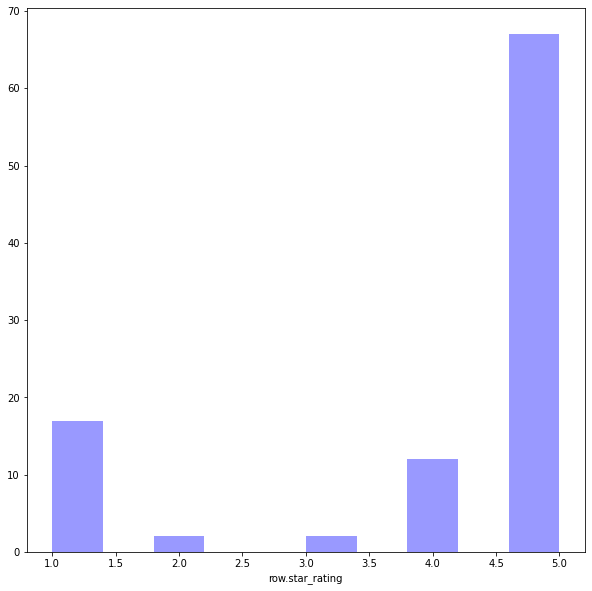

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(df['row.star_rating'], color='blue',kde=False)
plt.show()

## Training the model

In [ ]:
y = df['row.star_rating']
x = df['row.review_body']

In [ ]:
x

0     Used this for Elite Dangerous on my mac, an am...
1     Loved it,  I didn't even realise it was a gami...
2        poor quality work and not as it is advertised.
3     nice, but tend to slip away from stick in inte...
4     Great amiibo, great for collecting. Quality ma...
                            ...                        
95    Super nice base. It shoulb be a little more wi...
96    My 7 year old daughter and I love this game. W...
97                  Do you need a review for the PS4!!!
98             this is a fun little game for the family
99                                             Awesome!
Name: row.review_body, Length: 100, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=123)

In [ ]:
# Create TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(x_train)
X_test_tfidf = vectorizer.transform(x_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.72


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)


MultinomialNB()

In [ ]:


# Predict on the testing data
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.72


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.76
